In [4]:
# %% [markdown]
# ## Data Profiling, Cleaning & EDA
# ### Objective: Analyze solar data for Benin to derive actionable insights.

# %% [markdown]
# #### Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set global styles for plots
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [2]:
import pandas as pd
# Load raw data
df = pd.read_csv('data/sierraleone-bumbuna.csv', parse_dates=['Timestamp'])
print("Data Shape:", df.shape)
df.head(3)

# %% [markdown]
# #### Summary Statistics & Missing Values
# Generate descriptive stats and check for null values.
# Key columns: GHI, DNI, DHI, ModA, ModB, WS, WSgust.

# Summary stats
summary = df.describe(percentiles=[0.25, 0.5, 0.75]).T
summary['IQR'] = summary['75%'] - summary['25%']

# Missing values
missing = df.isna().sum().to_frame(name='Missing')
missing['Missing (%)'] = (missing['Missing'] / len(df)) * 100
missing = missing[missing['Missing'] > 0]

display(summary.style.background_gradient(cmap='Blues'))
display(missing.style.background_gradient(cmap='Reds'))

Data Shape: (525600, 19)


In [5]:
# %% [markdown]
# #### Handle Missing Values
# Impute with median for key columns if missing <5%. Drop rows if >5%.

key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Impute missing values with median
for col in key_columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# %% [markdown]
# #### Detect Outliers Using Z-Scores
# Flag rows where |Z| > 3 for key metrics.

z_scores = np.abs(stats.zscore(df[key_columns]))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers: {outliers.sum()}")

# Remove outliers (or impute based on context)
df_clean = df[~outliers].copy()

Number of outliers: 16292


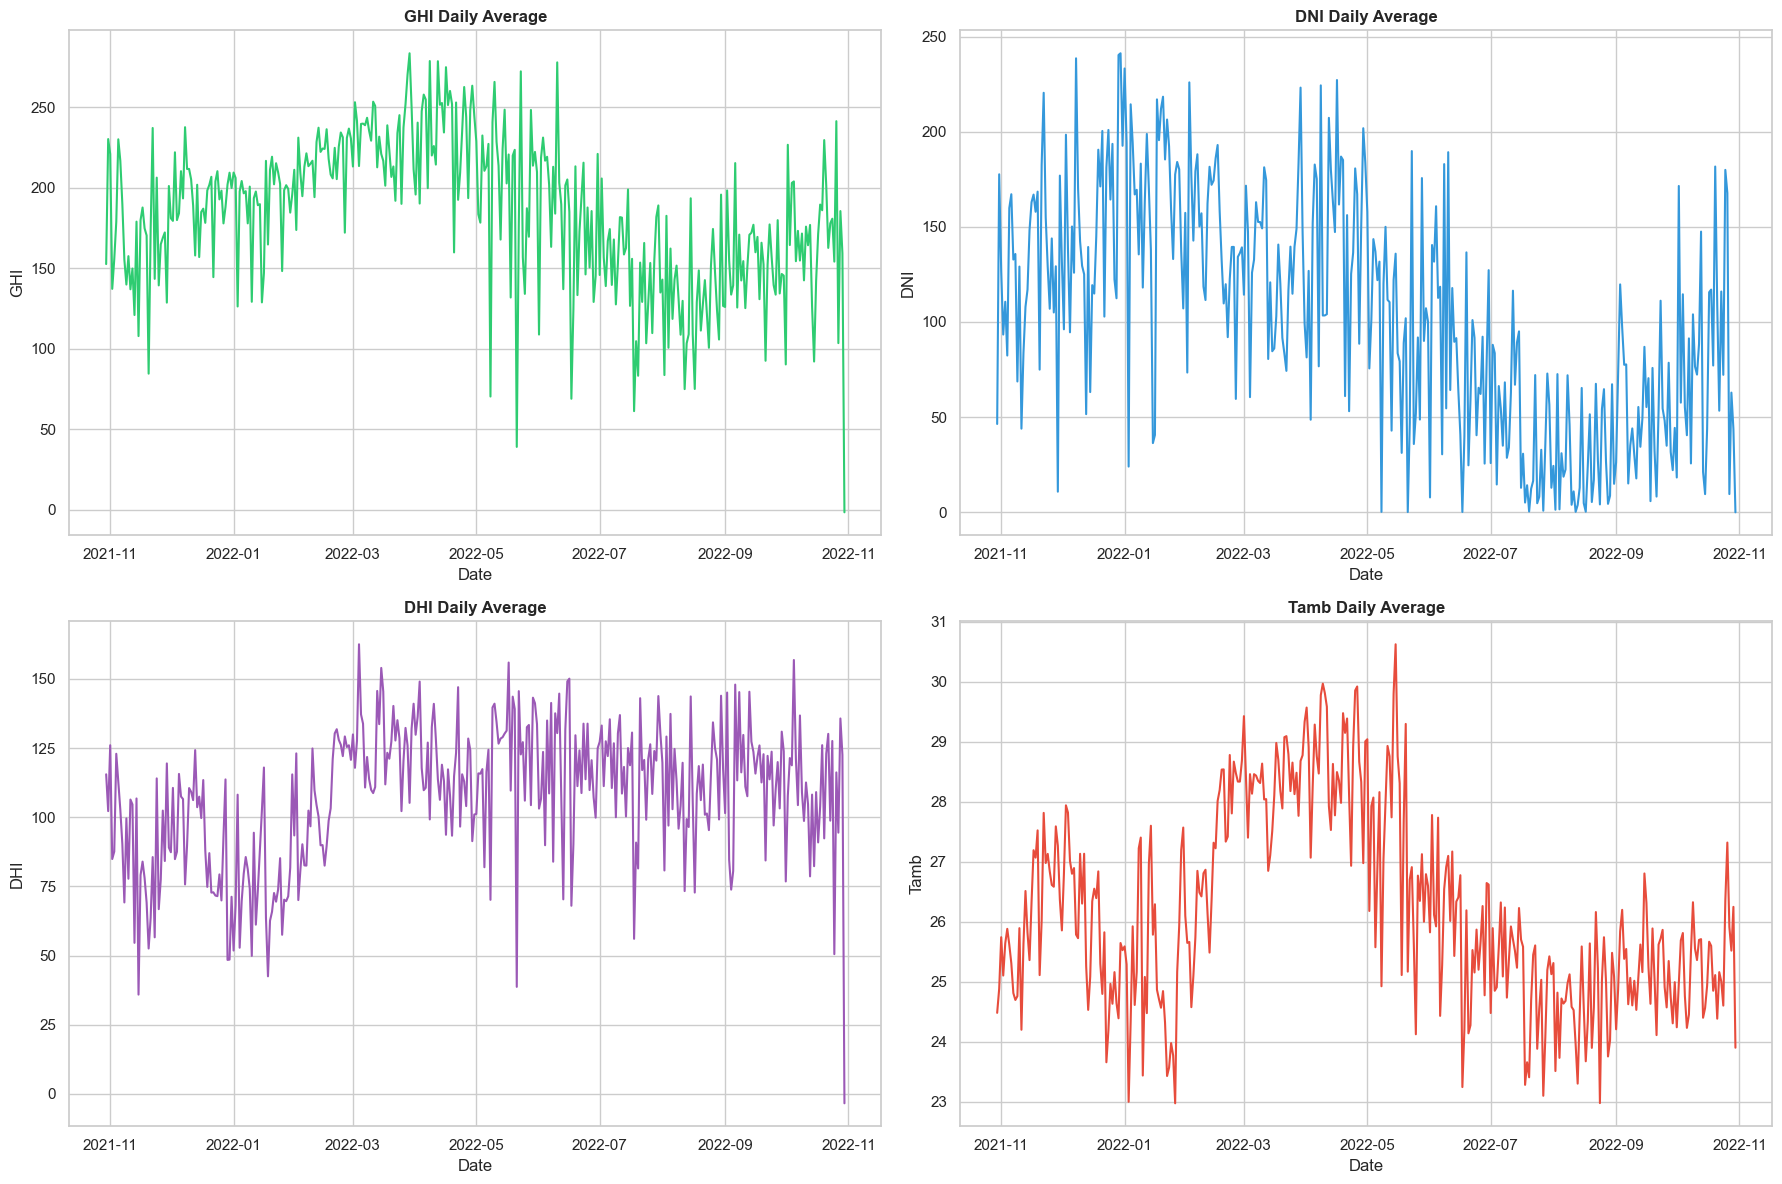

In [6]:
# %% [markdown]
# #### Solar Irradiance Trends Over Time
# Resample to daily averages for smoother visualization.

df_time = df_clean.set_index('Timestamp').resample('D').mean()

fig, ax = plt.subplots(2, 2, figsize=(18, 12))
metrics = ['GHI', 'DNI', 'DHI', 'Tamb']
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c']

for i, metric in enumerate(metrics):
    row, col = i // 2, i % 2
    sns.lineplot(data=df_time, x=df_time.index, y=metric, ax=ax[row, col], color=colors[i])
    ax[row, col].set_title(f'{metric} Daily Average', fontweight='bold')
    ax[row, col].set_xlabel('Date')
    ax[row, col].set_ylabel(metric)

plt.tight_layout()
plt.show()

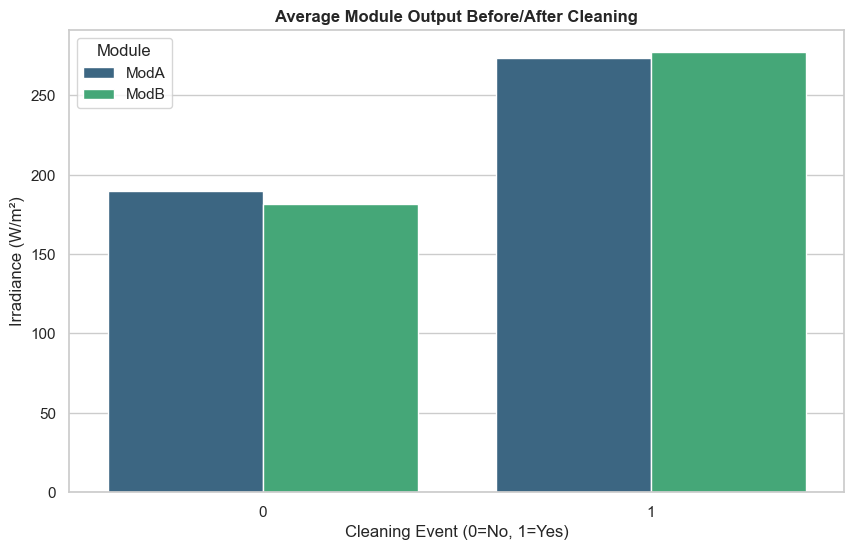

In [7]:
# %% [markdown]
# #### Module Performance Before/After Cleaning
# Group by 'Cleaning' flag and compare sensor readings.

cleaning_effect = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=pd.melt(cleaning_effect, id_vars='Cleaning'), 
            x='Cleaning', y='value', hue='variable', palette='viridis')
plt.title('Average Module Output Before/After Cleaning', fontweight='bold')
plt.xlabel('Cleaning Event (0=No, 1=Yes)')
plt.ylabel('Irradiance (W/m²)')
plt.legend(title='Module')
plt.show()

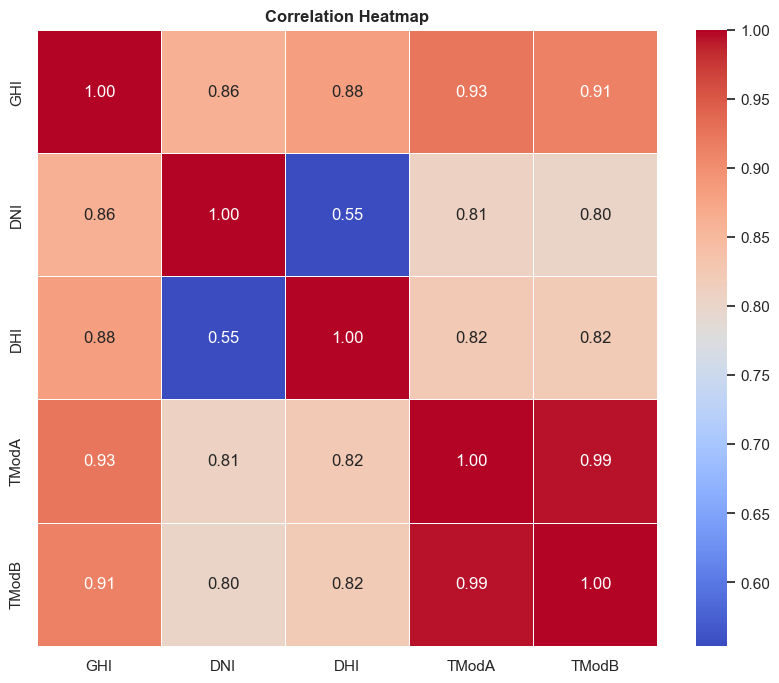

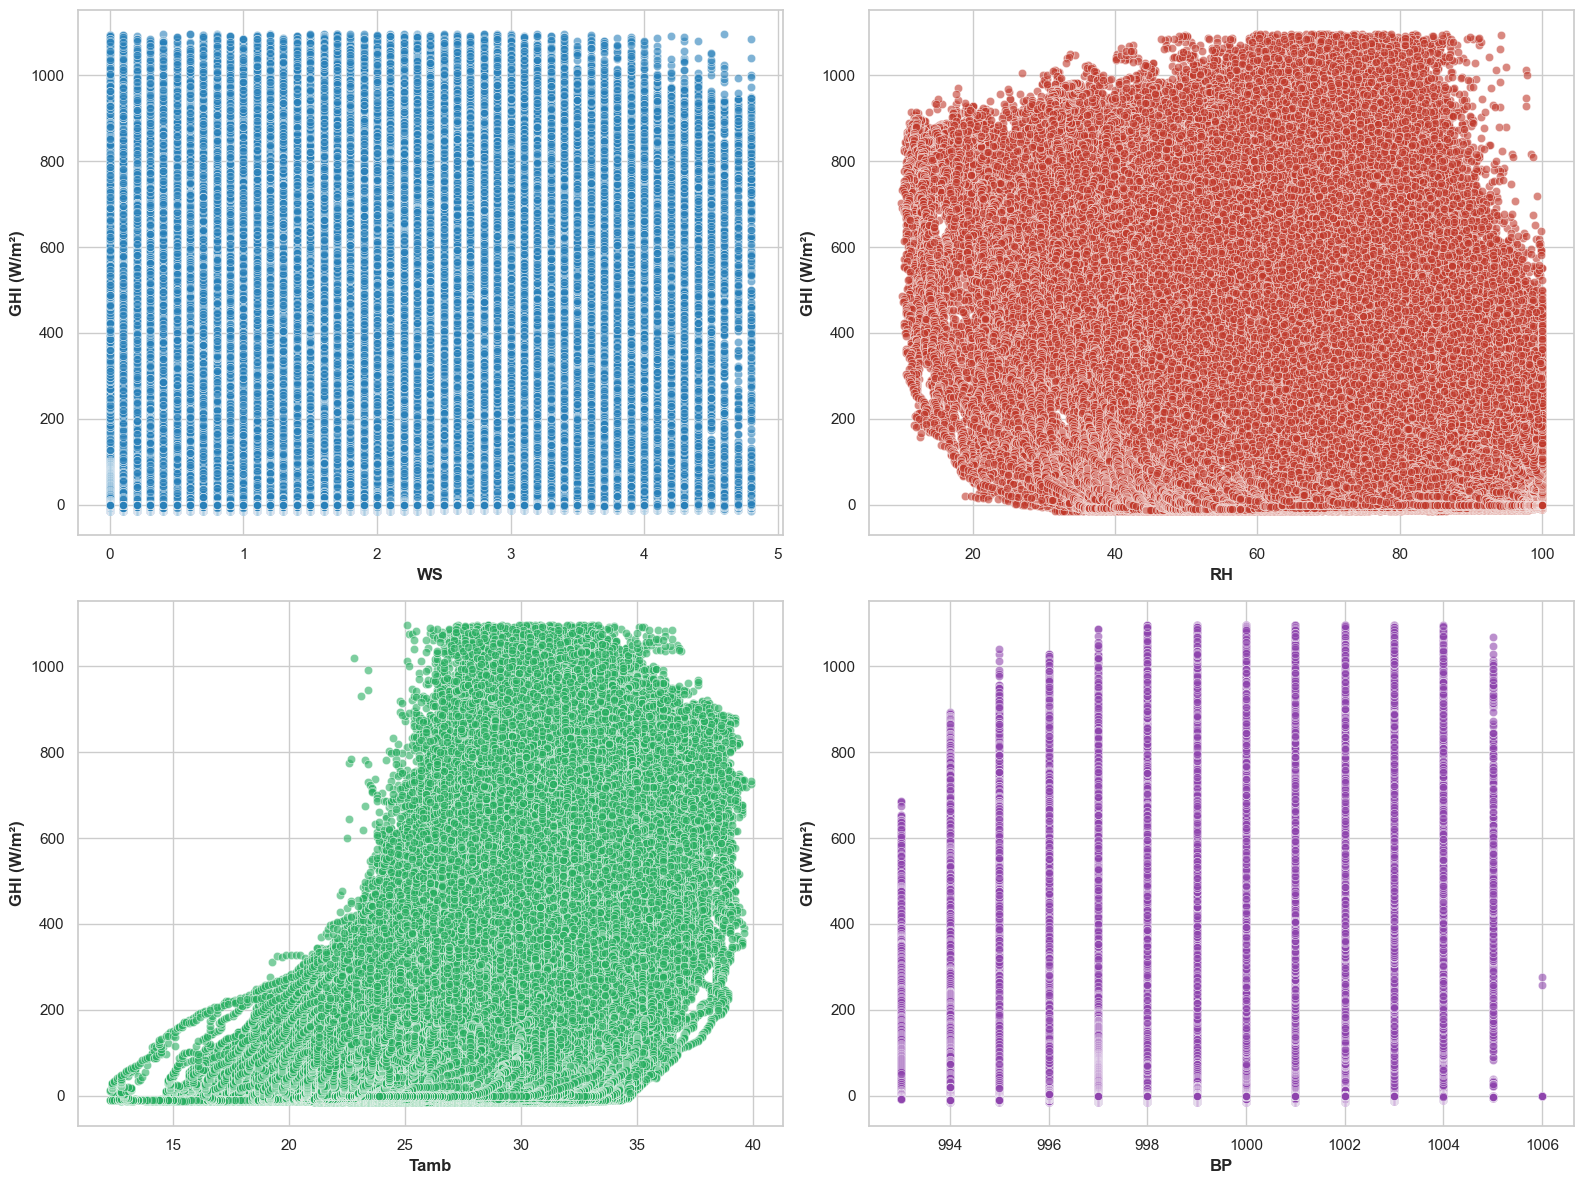

In [8]:
# %% [markdown]
# #### Heatmap of Key Metrics
corr_matrix = df_clean[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontweight='bold')
plt.show()

# %% [markdown]
# #### Scatter Plots: Environmental Factors vs. GHI
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.scatterplot(data=df_clean, x='WS', y='GHI', ax=ax[0, 0], alpha=0.6, color='#2980b9')
sns.scatterplot(data=df_clean, x='RH', y='GHI', ax=ax[0, 1], alpha=0.6, color='#c0392b')
sns.scatterplot(data=df_clean, x='Tamb', y='GHI', ax=ax[1, 0], alpha=0.6, color='#27ae60')
sns.scatterplot(data=df_clean, x='BP', y='GHI', ax=ax[1, 1], alpha=0.6, color='#8e44ad')

for axes in ax.flat:
    axes.set_xlabel(axes.get_xlabel(), fontweight='bold')
    axes.set_ylabel('GHI (W/m²)', fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# Function to convert degrees to 8 cardinal directions
def wind_direction(degree):
    # Adjust degrees to handle cyclicality (0° = 360°)
    degree = degree % 360
    if 337.5 <= degree or degree < 22.5:
        return 'N'
    elif 22.5 <= degree < 67.5:
        return 'NE'
    elif 67.5 <= degree < 112.5:
        return 'E'
    elif 112.5 <= degree < 157.5:
        return 'SE'
    elif 157.5 <= degree < 202.5:
        return 'S'
    elif 202.5 <= degree < 247.5:
        return 'SW'
    elif 247.5 <= degree < 292.5:
        return 'W'
    elif 292.5 <= degree < 337.5:
        return 'NW'

# Apply the function to create wind direction categories
df_clean['Wind_Dir_Category'] = df_clean['WD'].apply(wind_direction)

In [13]:
# Check for NaN in 'WD'
print("Missing 'WD' values:", df_clean['WD'].isna().sum())

# Drop rows with NaN (or impute with 0 if appropriate)
df_clean = df_clean.dropna(subset=['WD'])

Missing 'WD' values: 0


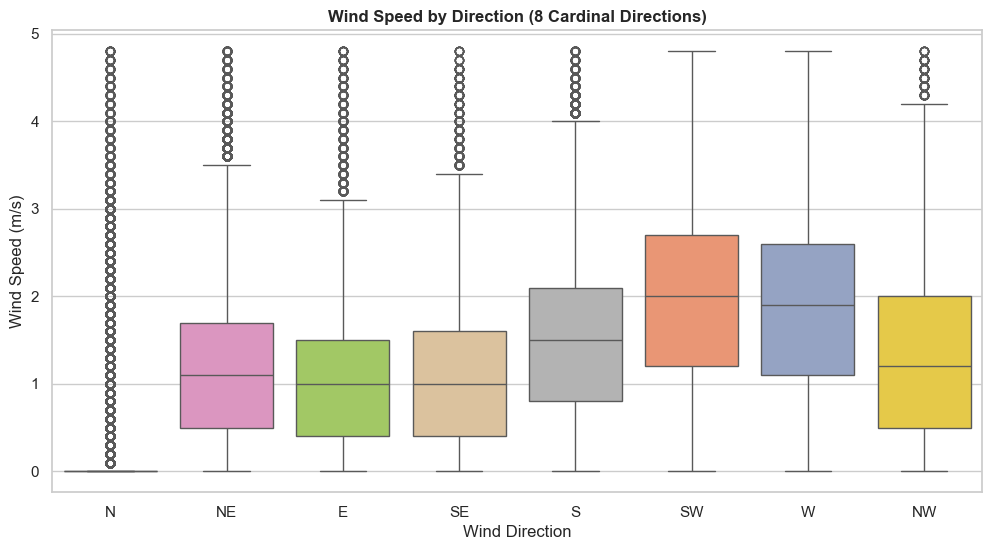

In [14]:
plt.figure(figsize=(12, 6))

# Order categories clockwise for intuitive visualization
order = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']

sns.boxplot(
    data=df_clean,
    x='Wind_Dir_Category',
    y='WS',
    palette='Set2',
    order=order,
    hue='Wind_Dir_Category',
    legend=False
)

plt.title('Wind Speed by Direction (8 Cardinal Directions)', fontweight='bold')
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed (m/s)')
plt.show()

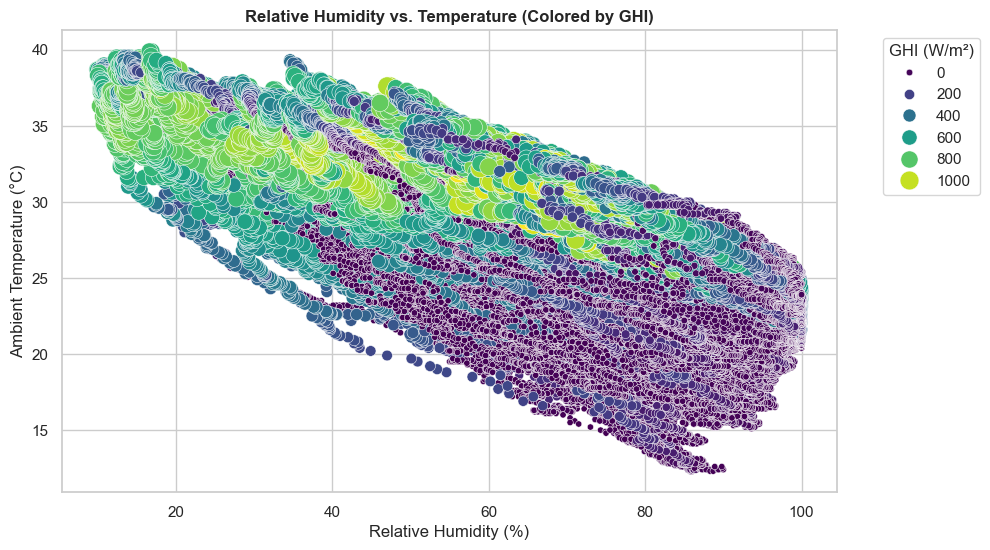

In [15]:
# %% [markdown]
# #### RH vs. Temperature with GHI Intensity
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df_clean, x='RH', y='Tamb', hue='GHI', 
                          palette='viridis', size='GHI', sizes=(20, 200))
plt.title('Relative Humidity vs. Temperature (Colored by GHI)', fontweight='bold')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.legend(title='GHI (W/m²)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

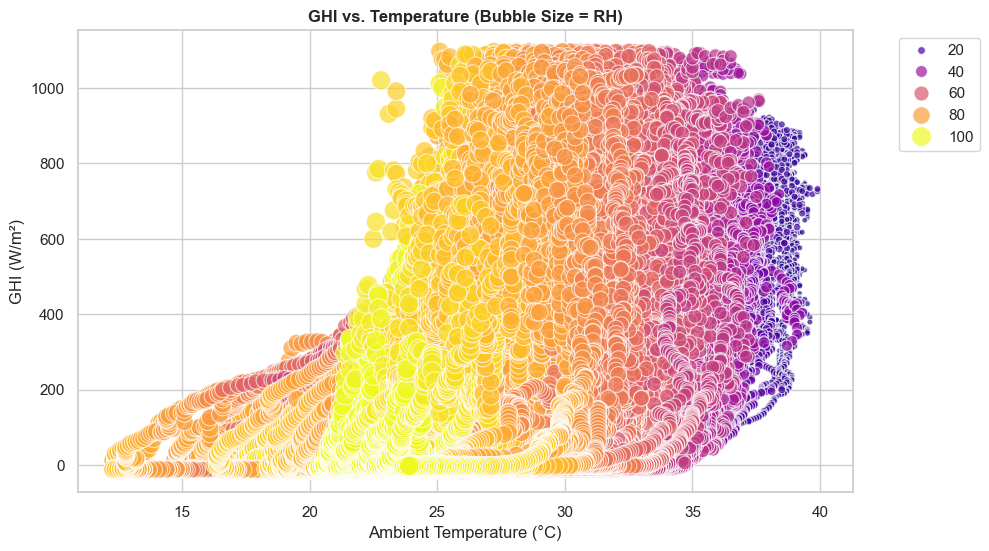

In [16]:
# %% [markdown]
# #### GHI vs. Ambient Temperature with RH as Bubble Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='Tamb', y='GHI', size='RH', hue='RH',
                palette='plasma', sizes=(10, 200), alpha=0.7)
plt.title('GHI vs. Temperature (Bubble Size = RH)', fontweight='bold')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
# Save cleaned data (ensure data/ is in .gitignore)
df_clean.to_csv('data/seirraleone_clean.csv', index=False)